# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Import modules

In [189]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
% matplotlib inline

import warnings
warnings.simplefilter('ignore')


## Data Import and Load

In [151]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
#Check Data 
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [7]:

profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
transcript.shape, profile.shape, portfolio.shape

((306534, 4), (17000, 5), (10, 6))

## Data Preprocessing

**Cleaning Portfolio Table**

In [10]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [153]:
# checking the distinct list of channels 
channels = set()

for i in portfolio['channels']:
    channels.update(set(i))
channels

{'email', 'mobile', 'social', 'web'}

In [152]:
clean_porfolio = portfolio.copy()

In [154]:
#split channel 
for i in channels:
    clean_porfolio[i] = clean_porfolio['channels'].apply(lambda x: i in x).map({True : 1, False : 0})

In [155]:
# drop the channel columns
clean_porfolio.drop(['channels'], axis =1 , inplace = True)

In [156]:
## checking NaN value 
clean_porfolio.isna().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
social        0
email         0
web           0
mobile        0
dtype: int64

In [157]:
clean_porfolio.head()

,difficulty,duration,id,offer_type,reward,social,email,web,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,1,0


In [17]:
# remove offer_type 
clean_porfolio.drop(['offer_type'],axis= 1 , inplace = True)
clean_porfolio

,difficulty,duration,id,reward,social,email,web,mobile,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,1,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,1,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,1,1,0,1,0


**Clean Profile Table**

In [18]:

profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [20]:
clean_profile = profile.copy()

In [21]:
# convert to datetime 
clean_profile['became_member_on'] = pd.to_datetime((clean_profile['became_member_on']),format='%Y%m%d')

In [22]:
clean_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [23]:
# Derived column for age of membership 
clean_profile['membershipage'] = pd.datetime.now() - clean_profile['became_member_on']
clean_profile['membershipage'] = clean_profile['membershipage'] / np.timedelta64(1,'Y')
clean_profile['member_start_year'] = clean_profile['became_member_on'].dt.year


In [24]:
clean_profile.head()

,age,became_member_on,gender,id,income,membershipage,member_start_year
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,3.092791,2017
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2.673891,2017
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1.682769,2018
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2.857331,2017
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2.619133,2017


In [25]:
clean_profile.isna().sum()

age                     0
became_member_on        0
gender               2175
id                      0
income               2175
membershipage           0
member_start_year       0
dtype: int64

In [26]:
##fill NaN 

clean_profile['gender'].fillna('NA', inplace = True)
clean_profile['income'].fillna(profile['income'].mean(), inplace = True)
clean_profile.isna().sum()

age                  0
became_member_on     0
gender               0
id                   0
income               0
membershipage        0
member_start_year    0
dtype: int64

In [27]:
##checking describe 
clean_profile.describe()

,age,income,membershipage,member_start_year
count,17000.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,3.061168,2016.635000
std,26.738580,20169.288288,1.125893,1.177624
min,18.000000,30000.000000,1.644438,2013.000000
25%,45.000000,51000.000000,2.213923,2016.000000
50%,58.000000,65404.991568,2.624609,2017.000000
75%,73.000000,76000.000000,3.810123,2017.000000
max,118.000000,120000.000000,6.635643,2018.000000


**Clearn Transcript Table**

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
clean_transcript = transcript.copy()

In [30]:
# check the number of each event 
clean_transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [31]:
##check NaN value 
clean_transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
#value column looks weird, clean this column. It looks like a dictionary. based on the key, value pair, we split 

info = []
for idx, row in clean_transcript.iterrows():
    for i in row['value']:
        if i in info:
            continue
        else:
            info.append(i)
info



['offer id', 'amount', 'offer_id', 'reward']

In [33]:
clean_transcript['offer_id'] = ''
clean_transcript['amount'] = 0
clean_transcript['reward'] = 0 

for idx, row in clean_transcript.iterrows():
    for i in row['value']:
        if i == 'offer id' or i == 'offer_id':
            clean_transcript.at[idx, 'offer_id'] = row['value'][i]
        if i == 'amount':
            clean_transcript.at[idx, 'amount'] = row['value'][i]
        if i == 'reward':
            clean_transcript.at[idx, 'reward'] = row['value'][i]


In [34]:
clean_transcript.drop(['value'], axis =1 , inplace = True)

In [35]:
clean_transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


## EDA

In [36]:
clean_profile.head()

,age,became_member_on,gender,id,income,membershipage,member_start_year
0,118,2017-02-12,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,3.092791,2017
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2.673891,2017
2,118,2018-07-12,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1.682769,2018
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2.857331,2017
4,118,2017-08-04,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568,2.619133,2017


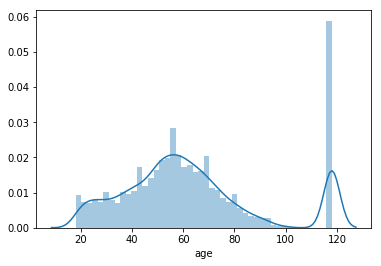

In [37]:
## Age Distribution 
sns.distplot(clean_profile['age'],norm_hist=True)

In [38]:
## based on the chart , age 118 looks weird and we would like to remove this data 
clean_profile.drop(clean_profile[clean_profile['age']==118].index,axis =0, inplace = True )


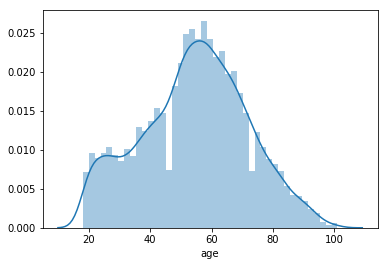

In [39]:
##Cleaned Age Distribution 
sns.distplot(clean_profile['age'],norm_hist=True)

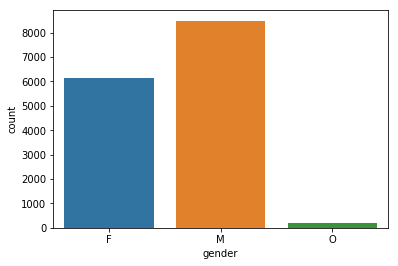

In [40]:
## Gender Counts 
sns.countplot(clean_profile['gender'])

In [41]:
# looks like gender O should not exist, just clean it 
clean_profile.drop (clean_profile[clean_profile['gender']=='O'].index, axis = 0,inplace = True)

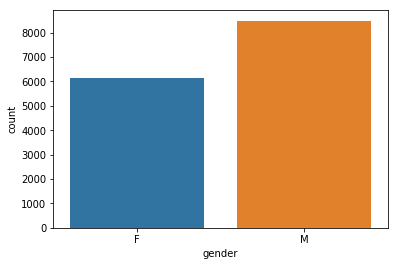

In [42]:
##Cleaned Gender Counts 
sns.countplot(clean_profile['gender'])

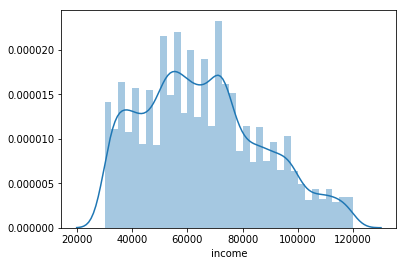

In [43]:
## Salary Distribution 
sns.distplot(clean_profile['income'])

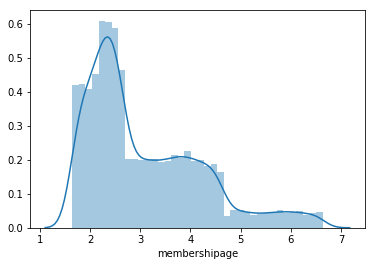

In [44]:
# membership age's distribution

sns.distplot(clean_profile['membershipage'])

Text(0,0.5,'Total Number')

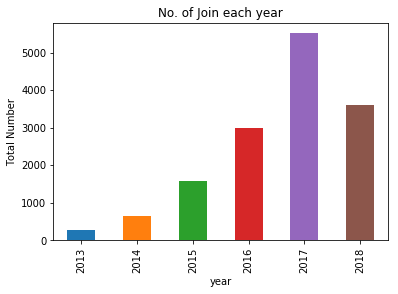

In [45]:
# number of member join in each year 
clean_profile['member_start_year'] = clean_profile['became_member_on'].dt.year 
mem_start = clean_profile.groupby('member_start_year').count()['id']
mem_start.plot(kind='bar')
plt.title('No. of Join each year')
plt.xlabel('year')
plt.ylabel('Total Number')

count     14613.000000
mean      65435.707931
std       21633.524110
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


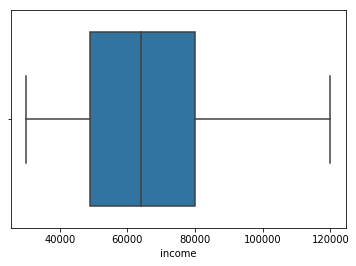

In [46]:
#Customer Income analysis

sns.boxplot(clean_profile['income'],)
print(clean_profile['income'].describe())

count    14613.000000
mean        54.393417
std         17.400201
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


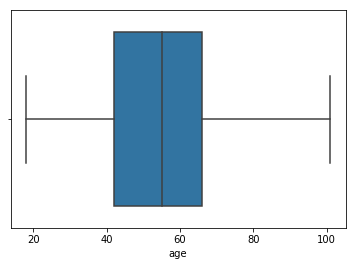

In [47]:
# Customer Age Analyssi 
sns.boxplot(clean_profile['age'])
print(clean_profile['age'].describe())

count    14613.000000
mean         3.076339
std          1.149050
min          1.644438
25%          2.213923
50%          2.624609
75%          3.829288
max          6.635643
Name: membershipage, dtype: float64


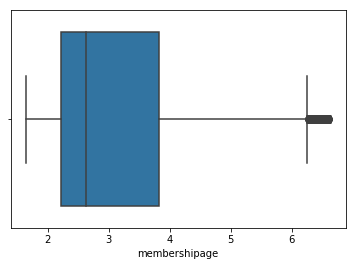

In [48]:
# membership age analysis
sns.boxplot(clean_profile['membershipage'])
print(clean_profile['membershipage'].describe())

In [49]:
df = pd.merge(left=clean_transcript, right=portfolio, how='left', left_on= 'offer_id', right_on= 'id')
df.head()

,event,person,time,offer_id,amount,reward_x,channels,difficulty,duration,id,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0


In [50]:
df['offer_type']= df['offer_type'].fillna('NA')

Text(0.5,0,'Offer Type')

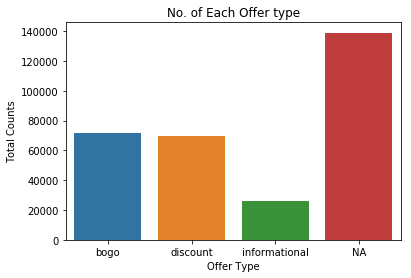

In [51]:
#offer type count 
sns.countplot(df['offer_type'])
plt.title('No. of Each Offer type')
plt.ylabel('Total Counts')
plt.xlabel('Offer Type')


**we can see almost 45% customer, we do not provide any offer**

In [52]:
## based on age, classify group 
clean_profile['age_category'] = pd.cut(clean_profile['age'], bins = [0,12,18,21,64,150], labels=['Kid','Teenager','Young', 'Adult','Elderly'])

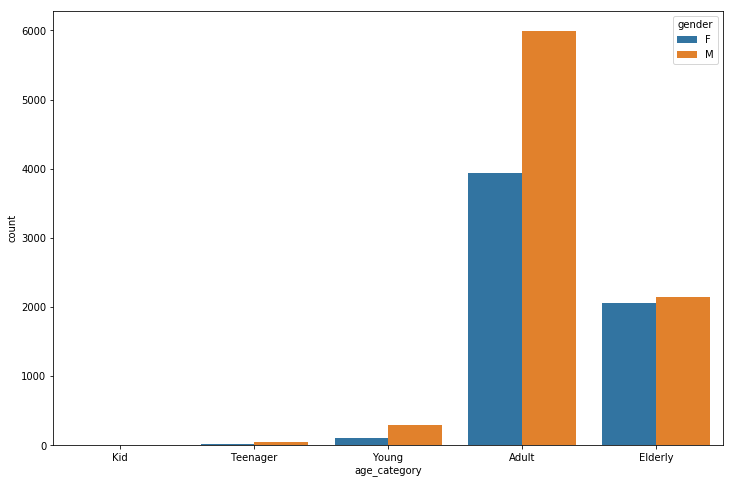

In [53]:
## age category count 
plt.figure(figsize=(12,8))
sns.countplot('age_category',hue ='gender', data = clean_profile)

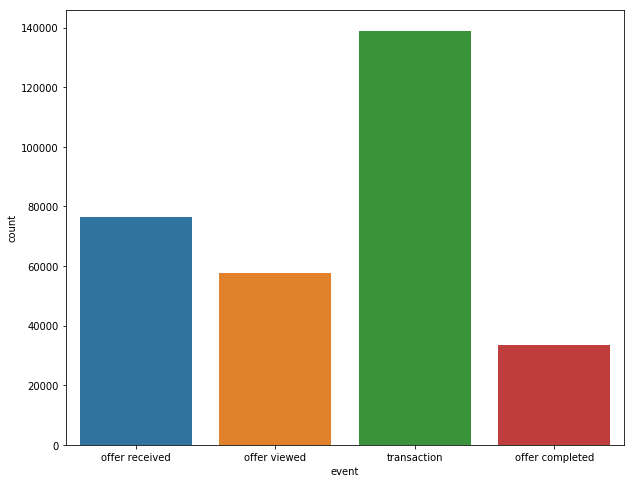

In [54]:
## Transaction event count 
plt.figure(figsize = (10,8))
sns.countplot(clean_transcript['event'])

In [55]:
customer_expense = df[(df['event']=='offer completed')|(df['event']=='transaction')].groupby(['person','event'])['amount'].sum().reset_index()

In [56]:
##top expense customer information
customer_expense.sort_values('amount', ascending=False).head(10)

,person,event,amount
6956,3c8d541112a74af99e88abbd0692f00e,transaction,1606
27773,f1d65ae63f174b8f80fa063adcaa63b7,transaction,1360
20207,ae6f43089b674728a50b8727252d3305,transaction,1320
11265,626df8678e2a4953b9098246418c9cfa,transaction,1314
13252,73afdeca19e349b98f09e928644610f8,transaction,1314
9486,52959f19113e4241a8cb3bef486c6412,transaction,1285
20048,ad1f0a409ae642bc9a43f31f56c130fc,transaction,1256
24173,d240308de0ee4cf8bb6072816268582b,transaction,1244
17094,946fc0d3ecc4492aa4cc06cf6b1492c3,transaction,1224
11482,6406abad8e2c4b8584e4f68003de148d,transaction,1206


In [63]:
#combine 3 tables 
combined_table = pd.merge(left= df, right= clean_profile, how = 'inner', left_on='person', right_on='id')

In [73]:
combined_table.isna().sum()

event                     0
person                    0
time                      0
offer_id                  0
amount                    0
reward_x                  0
channels             122176
difficulty           122176
duration             122176
id_x                 122176
offer_type                0
reward_y             122176
age                       0
became_member_on          0
gender                    0
id_y                      0
income                    0
membershipage             0
member_start_year         0
age_category              0
dtype: int64

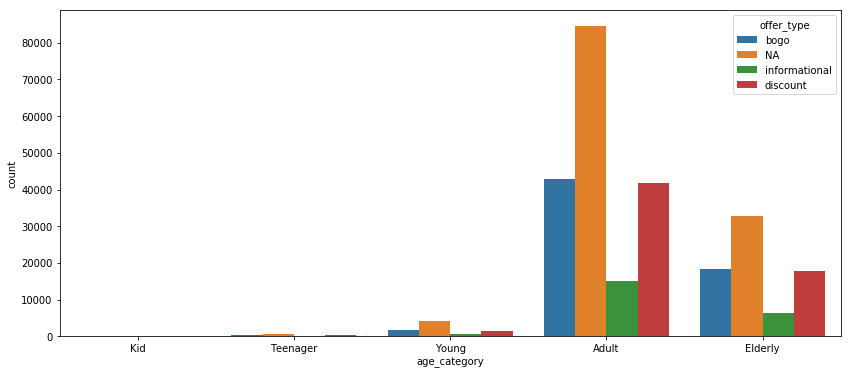

In [72]:
plt.figure(figsize=(14,6))
sns.countplot('age_category',hue= 'offer_type' , data=combined_table)

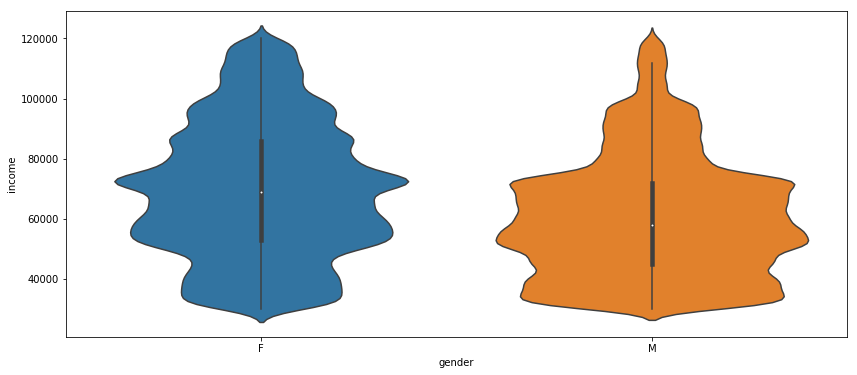

In [74]:
# Salary information by Gender
plt.figure(figsize=(14,6))
sns.violinplot(combined_table['gender'], combined_table['income'])

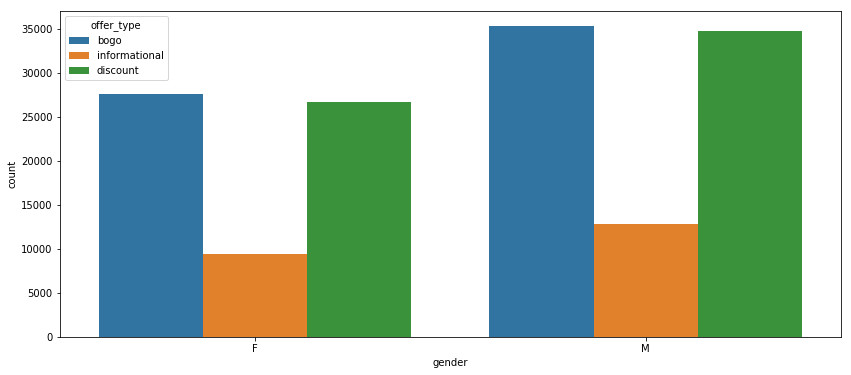

In [79]:
## which of promotion each gender like 

#since Offer type has a lot NA value, which means nothing for us 
gender_data = combined_table[combined_table['offer_type'] != 'NA']
plt.figure(figsize=(14,6))
sns.countplot(combined_table['gender'],hue = 'offer_type' , data=gender_data)

Looks like most people like Bogo and discount 


## Data Modeling 

**in this part , we will build ML model that predict the customer will take the offer or not**

In [158]:
# in my model, i would like to predict by offer type, so , if the customer do not have any offer, i do not care about those data 

clean_transcript=clean_transcript[clean_transcript['offer_id']!='']

In [159]:
clean_transcript.shape, clean_profile.shape, clean_porfolio.shape

((167581, 6), (14613, 8), (10, 9))

In [160]:
data_set = pd.merge(left=clean_transcript,right= clean_porfolio, how ='inner', left_on='offer_id', right_on= 'id')

In [161]:
data_set.drop(['reward_x','id', 'reward_y'],axis = 1, inplace = True)

In [162]:
data_set = pd.merge(left=data_set, right = clean_profile, how='outer', left_on='person',right_on='id')

In [163]:
data_set['gender'] = data_set['gender'].apply(lambda x : 1 if x =='M' else 0)

In [164]:
data_set.drop(['id','became_member_on'],axis = 1, inplace = True)

In [165]:
event = pd.get_dummies(data_set['event'])

In [166]:
data_set = pd.concat([data_set, event], axis = 1)

In [167]:
data_set.drop(['event'], axis = 1 , inplace = True)

In [169]:
data_set.head()

,person,time,offer_id,amount,difficulty,duration,offer_type,social,email,web,mobile,age,gender,income,membershipage,member_start_year,age_category,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0,75.0,0,100000.0,2.857331,2017.0,Elderly,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,6.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0,75.0,0,100000.0,2.857331,2017.0,Elderly,0,0,1
2,78afa995795e4d85b5d9ceeca43f5fef,132.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5.0,7.0,bogo,0.0,1.0,1.0,1.0,75.0,0,100000.0,2.857331,2017.0,Elderly,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,75.0,0,100000.0,2.857331,2017.0,Elderly,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef,510.0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,75.0,0,100000.0,2.857331,2017.0,Elderly,1,0,0


In [170]:
model_data= data_set.groupby(['person','offer_type','age','income','gender']).agg(
        {
            'offer completed':sum,
            'offer received' : sum,
            'offer viewed': sum,
            
        }

        ).reset_index()

In [172]:
def transformation(df):
    df['bogo_received'] = 0 
    df['bogo_completed'] = 0
    df['discount_received'] = 0
    df['discount_completed'] = 0 
    
    for idx, row in df.iterrows():
        if (row['offer_type'] =='bogo'):
            df.loc[idx,'bogo_completed'] = row['offer completed']
            df.loc[idx,'bogo_received'] = row['offer received']
        elif (row['offer_type']== 'discount'):
            df.loc[idx, 'discount_completed'] = row['offer completed']
            df.loc[idx, 'discount_received'] = row['offer received']
            
    return df.groupby(['person']).agg(
    {
        'age' :'last',
        'gender': 'last',
        'income':'last',
        'bogo_received': sum,
        'bogo_completed': sum,
        'discount_received': sum, 
        'discount_completed': sum
    }).reset_index()

In [173]:
trans_data = transformation(model_data)

In [180]:
# change to percentage 
trans_data['bogo_perce'] = trans_data['bogo_completed'].div(trans_data['bogo_received'].where(trans_data['bogo_received']!= 0, np.nan))*100
trans_data['discount_perce'] = trans_data['discount_completed'].div(trans_data['discount_received'].where(trans_data['discount_received']!= 0, np.nan))*100

In [182]:
trans_data.fillna(0,inplace = True)

In [183]:
trans_data['bogo_offer'] = 0 
trans_data['discount_offer'] = 0 

for i , row in trans_data.iterrows():
    if (row['bogo_perce']  >= 75):
        trans_data.loc[i,'bogo_offer'] = 1 
    if (row['discount_perce'] >=75) :
        trans_data.loc[i, 'discount_offer'] = 1 
        

In [184]:
trans_data.head()

,person,age,gender,income,bogo_received,bogo_completed,discount_received,discount_completed,bogo_perce,discount_perce,bogo_offer,discount_offer
0,0009655768c64bdeb2e877511632db8f,33.0,1,72000.0,1,1,2,2,100.0,100.0,1,1
1,0020c2b971eb4e9188eac86d93036a77,59.0,0,90000.0,2,1,2,2,50.0,100.0,0,1
2,0020ccbbb6d84e358d3414a3ff76cffd,24.0,0,60000.0,2,2,1,1,100.0,100.0,1,1
3,003d66b6608740288d6cc97a6903f4f0,26.0,0,73000.0,0,0,3,3,0.0,100.0,0,1
4,00426fe3ffde4c6b9cb9ad6d077a13ea,19.0,0,65000.0,0,0,4,1,0.0,25.0,0,0


In [185]:
#Feature Selection 

X = trans_data.drop(['person','bogo_offer','discount_offer'], axis = 1 )
y_bogo = trans_data['bogo_offer']
y_discount = trans_data['discount_offer']


In [186]:
## train_ test split 
X_train, X_test, y_train_bogo, y_test_bogo = train_test_split(X, y_bogo, test_size=0.3, random_state=42)
X_train, X_test, y_train_discount, y_test_discount = train_test_split(X, y_discount, test_size=0.3, random_state=42)

## KNN

In [187]:
#fit KNN modele
from sklearn.neighbors import KNeighborsClassifier 

knn_bogo = KNeighborsClassifier()
knn_bogo.fit(X_train, y_train_bogo)

knn_discount = KNeighborsClassifier()
knn_discount.fit(X_train, y_train_discount)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [188]:
# KNN model predict 
bogo_pred = knn_bogo.predict(X_test)
discount_pred = knn_discount.predict(X_test)

In [194]:
# KNN MODEL evaluation 
print('Bogo offer KNN Model Accuray {}'.format(accuracy_score(y_test_bogo, bogo_pred)))
print('Discount offer KNN Model Accuray {}'.format(accuracy_score(y_test_discount, discount_pred)))
print('Bogo offer KNN Model classification_report {}'.format(classification_report(y_test_bogo, bogo_pred)))
print('Discount offer KNN Model classification_report {}'.format(classification_report(y_test_discount, discount_pred)))

Bogo offer KNN Model Accuray 0.9901893680127767
Discount offer KNN Model Accuray 0.9840292037417294
Bogo offer KNN Model classification_report              precision    recall  f1-score   support

          0       0.99      0.99      0.99      2614
          1       0.99      0.99      0.99      1769

avg / total       0.99      0.99      0.99      4383

Discount offer KNN Model classification_report              precision    recall  f1-score   support

          0       0.99      0.98      0.98      2274
          1       0.98      0.99      0.98      2109

avg / total       0.98      0.98      0.98      4383



## Naive Bayes Model

In [198]:
#fit the NB model
NB_bogo = GaussianNB()
NB_discount = GaussianNB()

NB_bogo.fit(X_train, y_train_bogo)
NB_discount.fit(X_train, y_train_discount)

GaussianNB(priors=None)

In [199]:
## Naive Bayes model predict 
bogo_NB_pred = NB_bogo.predict(X_test)
discount_NB_pred = NB_discount.predict(X_test)

In [200]:
##Naive Bayes model evaluation 
print('Bogo offer NB Model Accuray {}'.format(accuracy_score(y_test_bogo, bogo_NB_pred)))
print('Discount offer NB Model Accuray {}'.format(accuracy_score(y_test_discount, discount_NB_pred)))
print('Bogo offer NB Model classification_report {}'.format(classification_report(y_test_bogo, bogo_NB_pred)))
print('Discount offer NB Model classification_report {}'.format(classification_report(y_test_discount, discount_NB_pred)))



Bogo offer NB Model Accuray 0.9853981291352955
Discount offer NB Model Accuray 0.9856262833675564
Bogo offer NB Model classification_report              precision    recall  f1-score   support

          0       0.98      1.00      0.99      2614
          1       1.00      0.96      0.98      1769

avg / total       0.99      0.99      0.99      4383

Discount offer NB Model classification_report              precision    recall  f1-score   support

          0       0.97      1.00      0.99      2274
          1       1.00      0.97      0.98      2109

avg / total       0.99      0.99      0.99      4383



## Support Vector Machine

In [201]:
# fit the SVM Model 
bogo_svm = SVC()
discount_svm = SVC()

bogo_svm.fit(X_train, y_train_bogo)
discount_svm.fit(X_train,y_train_discount)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [202]:
# SVM Model Predict 
bogo_svm_pred = bogo_svm.predict(X_test)
discount_svm_pred = discount_svm.predict(X_test)

In [203]:
# SVM Model evalution 
print('Bogo offer SVM Model Accuray {}'.format(accuracy_score(y_test_bogo, bogo_svm_pred)))
print('Discount offer SVM Model Accuray {}'.format(accuracy_score(y_test_discount, discount_svm_pred)))
print('Bogo offer SVM Model classification_report {}'.format(classification_report(y_test_bogo, bogo_svm_pred)))
print('Discount offer SVM Model classification_report {}'.format(classification_report(y_test_discount, discount_svm_pred)))


Bogo offer SVM Model Accuray 0.8797627195984485
Discount offer SVM Model Accuray 0.8747433264887063
Bogo offer SVM Model classification_report              precision    recall  f1-score   support

          0       0.83      1.00      0.91      2614
          1       1.00      0.70      0.82      1769

avg / total       0.90      0.88      0.87      4383

Discount offer SVM Model classification_report              precision    recall  f1-score   support

          0       0.81      1.00      0.89      2274
          1       1.00      0.74      0.85      2109

avg / total       0.90      0.87      0.87      4383



## Conclusion

i build several different model to predict the offer we give. all of those model working great!. 
1> the highgtest accuracy of the model is KNN model in my case , around 99% and 98% accuracy for Bogo prediction and Discount Predition. 
2> Naive Bayes Model also performance well, both of prediction has 98% accuracy 
3> SVM not perfect like the other two, but still good. both prediction has 87% accuracy.